In [67]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
import pdb
from tools import plots


First, create a function to compute an arbitrary Sersic profile.

In [68]:
def profile(r, I_e, R_e=1., n=1., mag=False) :
    """
    routine to return Sersic profile

    Args:
        r:  array-like
            input array of radii at which to calculate profile
       I_e: float
            surface brightness at effective radius, in intensity or magnitude
            units, depending on mag
       R_e: float, optional
            effective radius, default=1.
       n:  sersic index (default=1, i.e. exponential)
       mag: bool, optional
            return in mag units if True, default=False
    """

    bn=1.99*n-0.327
    I_r = np.exp (-bn * ((r/R_e)**(1./n) - 1) )           # Sersic function
    if mag :
        return I_e - 2.5 *np.log10(I_r)
    else :
        return I_e * I_r


 Write a function to calculate flux in an annulus : 2 $\pi$ r SB(r)

In [69]:
def flux(r, I_e=0., R_e=1., n=1) :
    """ Helper routine to calculate annular flux at given radius for integrator
    """
    return 2*np.pi*r*profile(r,I_e,R_e,n=n)

Function to calculate and plot profiles at a range of different Sersic indices. Optionally calculate and plot cumulative profile.

In [70]:
def profiles(r=np.arange(0.,5.,0.01),ns=[0.6,1.0,1.4,2.0,2.6,3.2,4.0],
             I_e=1.,R_e=1.,cumulative=False, mag=True, R_e_max = 1000.) :
    """ Plot profiles of various Sersic indices

        r : arraylike, optional
            radii to calculate profiles at, default=np.arange(0.,5,0.01)
        ns : arraylike, optional
             set of Sersic indices to plot, default=[0.6,1.0,1.4,2.0,2.6,3.2,4.0]
        I_e : float, optional
             SB at effective radius, default=1.
        R_e : float, optional
             Effective radius, default=1.
        cumulative: bool, optional
             if True, plot cumulative profile
    """

    # get sum for n=1 (used only if cumulative=True), using scipy.integrate.quad() routine
    sum1 = quad(flux,0.,R_e_max,args=(I_e,R_e,1))

    # loop over Sersic indices, plotting each profile
    for n in ns :
        if cumulative :
            # integrate to R_e_max for normalizing total
            sum = quad(flux,0.,R_e_mmax,args=(1.,1.,n))

            # Integrate to each radius, wasteful since we keep integrating over same area!
            cum=[]
            for rr in r :
                cum.append(quad(flux,0.,rr,args=(1.,1.,n))[0]/sum[0])
   
            plt.plot(r,cum,label='n={:4.1f}'.format(n))
            print(n,sum[0]/sum1[0])
        else :
            plt.plot(r,profile(r,I_e,R_e,n=n,mag=mag),label='n={:4.1f}'.format(n))

    # annotate plot
    plt.legend()
    plt.xlabel('Radius (r/R_e)')
    if cumulative :
        plt.ylabel('Cumulative flux')
    else :
       
        # invert axes if magnitude units
        if mag: 
            plt.ylabel('Surface brightness (mag)')
            plt.ylim(plt.ylim()[::-1])
        else :
            plt.ylabel('Surface brightness')


Plot profiles at a range of indices

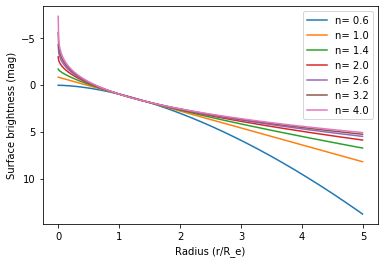

In [71]:
profiles()

Function to show multiple profiles with different R_e and Sersic n, normalized at some radius, used to construct Straatman Figure 1 plot

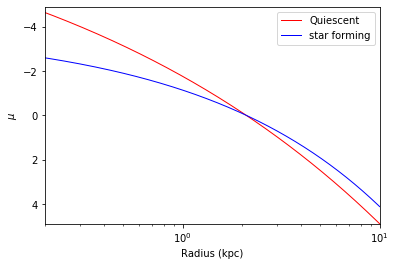

In [72]:
def straatman(R_es=[0.85,2.62],ns=[4.14,2.17],labels=['Quiescent','star forming'],colors=['red','blue'],rnorm=2.1) :
    """ Plot multiple Sersic profiles, normalized at some radius
    """
    r=np.arange(0.,10.,0.01)
    fig,ax=plots.multi(1,1)
    for R_e,n,label,color in zip(R_es,ns,labels,colors) :
        prof = profile(r,I_e=0.,R_e=R_e,n=n,mag=True)
        
        # construct an interpolating function
        interp=interp1d(r,prof)
        
        # interpolate at normalizing radius and plot
        norm = interp(rnorm)
        plots.plotl(ax,r,prof-norm,label=label,yr=[5,-5],xr=[0.1,10.1],
                    xt='Radius (kpc)',yt='$\mu$',color=color)

    ax.set_xscale('log')
    ax.legend()

straatman()

Routine to calculate Petrosian radius for a Sersic profile

In [75]:
def petro(R_e=1,n=1,eta=0.2, plot = False) :

    """ Calculate Petrosian radius for Sersic profile with index n

        I_e : float, optional
             SB at effective radius, default=1.
        n : float, optional
             Sersic index,  default=1.
        eta : float, optional
             Critical value of Petrosian ratio to determine Petrosian radius
    """

    # input radii to 10 R_e
    r=np.arange(0.,10.*R_e,0.01)
    ratio=[]
    I_e=1     # note Petrosian ratio independent of I_e!
    for rr in r :
        # integrate flux internal to rr
        tot=quad(flux,0.,rr,args=(I_e,R_e,n))[0]

        # Petrosian ratio = SB / average_internal_flux
        ratio.append(profile(rr,I_e,R_e,n=n)/(tot/(np.pi*rr**2)))

    # interpolate to desired ratio, eta
    interp=interp1d(ratio,r)
    petrorad = interp(eta)
    
    if plot :
        fig,ax=plots.multi(1,1)
        plots.plotl(ax,r,ratio,xt='Radius',yt='Petrosian ratio')
        ax.plot([petrorad,petrorad],plt.ylim())
        ax.grid()
        ax.set_title('R_e: {:.2f}   n: {:.2f}   R_petro : {:.2f}'.format(R_e,n,petrorad))

    return petrorad


Calculate Petrosian radius for Straatman et al quiescent and star forming stack model parameters

/Users/holtz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


star forming: R_p = 5.77
quiescent: R_p = 1.53


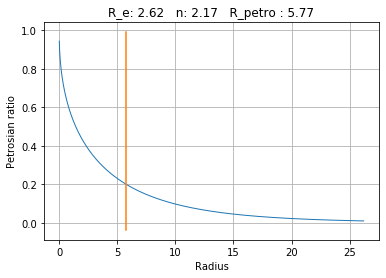

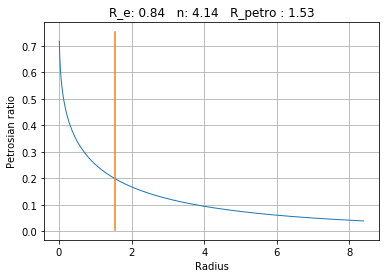

In [76]:
print('star forming: R_p = {:.2f}'.format(petro(R_e=2.62,n=2.17,plot=True)))
print('quiescent: R_p = {:.2f}'.format(petro(R_e=0.84,n=4.14,plot=True)))